In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import math

In [2]:
def LineGenerate(lenght, m):
    """
    Creating a line with m random segments
    """
    line = np.zeros(lenght,)
    ab = np.array(sorted(random.sample(range(0, lenght-1), m*2))) # random start and end of the segments
    ab = ab.reshape((m,2)) # start and end of the segments coordinates
    return ab

In [3]:
def MultipleLines(line_lenght, min_seg, max_seg, line_num, max_hight):
    seg_hights = sorted(random.sample(range(0, max_hight), line_num))
    lines = pd.DataFrame(columns = ['Start','End', 'Height', 'Line'])
    for i in range(line_num):
        line =  pd.DataFrame(LineGenerate(line_lenght, random.randrange(min_seg, max_seg)), columns = ['Start','End'])
        line["Height"] = seg_hights[i]
        line["Line"] = i
        lines = pd.concat([lines,line], ignore_index=True)
    return lines

In [4]:
l = 50 # max line lenght 
min_seg = 4 # min segments per line
max_seg = 5 # max segments per line
n = 3 # number of lines
max_hight = 50 # max hight of the higthest segment

In [5]:
base=[0,25]

In [6]:
lines = MultipleLines(l, min_seg, max_seg, n, max_hight)

In [7]:
n_vertices = lines.shape[0]*2
starts = lines['Start'].to_numpy()
ends = lines['End'].to_numpy()
hight = lines['Height'].to_numpy()
x = np.zeros(lines.shape[0]*2)
y =  np.zeros(lines.shape[0]*2)
for i in range(lines.shape[0]):
    x[i*2] = starts[i]
    x[i*2+1] = ends[i]
    y[i*2] = hight[i]
    y[i*2+1] = hight[i]    
edge = np.zeros([lines.shape[0],2])
for i in range(lines.shape[0]):
    edge[i] = [i*2,i*2+1]
g = ig.Graph(n_vertices, edge)

In [8]:
g.vs['x'] = x
g.vs['y'] = y

In [9]:
def AddSegments(g, segments):
    for i in range(segments.shape[0]):
        g.es[g.get_eid(int(segments[i,0]), int(segments[i,1]))]["is_segment"] = True  
        g.vs[int(segments[i,0]), int(segments[i,1])]["group"] = i
    g.es["is_segment"] = [False if is_segment is None else is_segment for is_segment in g.es["is_segment"]]

In [10]:
AddSegments(g, edge)

In [11]:
def PlotTheGraph(g):
    color_dict_vs = {True: "red", False: "black"}
    edge_width = [2 + 10 * int(is_segment) for is_segment in g.es["is_segment"]]
    vertex_color = [color_dict_vs[base] for base in g.vs["base"]]
    fig, ax = plt.subplots(figsize=(50,50))
    ig.plot(
        g,
        target=ax,
        layout='auto',
        vertex_size = 0.5,
        vertex_label = ["           Base"* int(base) for base in g.vs["base"]],
        vertex_label_size = 50,
        vertex_frame_width=4.0,
        vertex_color = vertex_color,
        edge_width = edge_width,
    )
    plt.show()

In [12]:
def AddBase(g, base):
    n=len(g.vs)
    g.add_vertices(1)
    g.vs[n]['x'] = base[1]
    g.vs[n]['y'] = base[0]
    g.vs[n]["base"] = True
    g.vs[0:n]["base"] = False

In [13]:
AddBase(g, base)

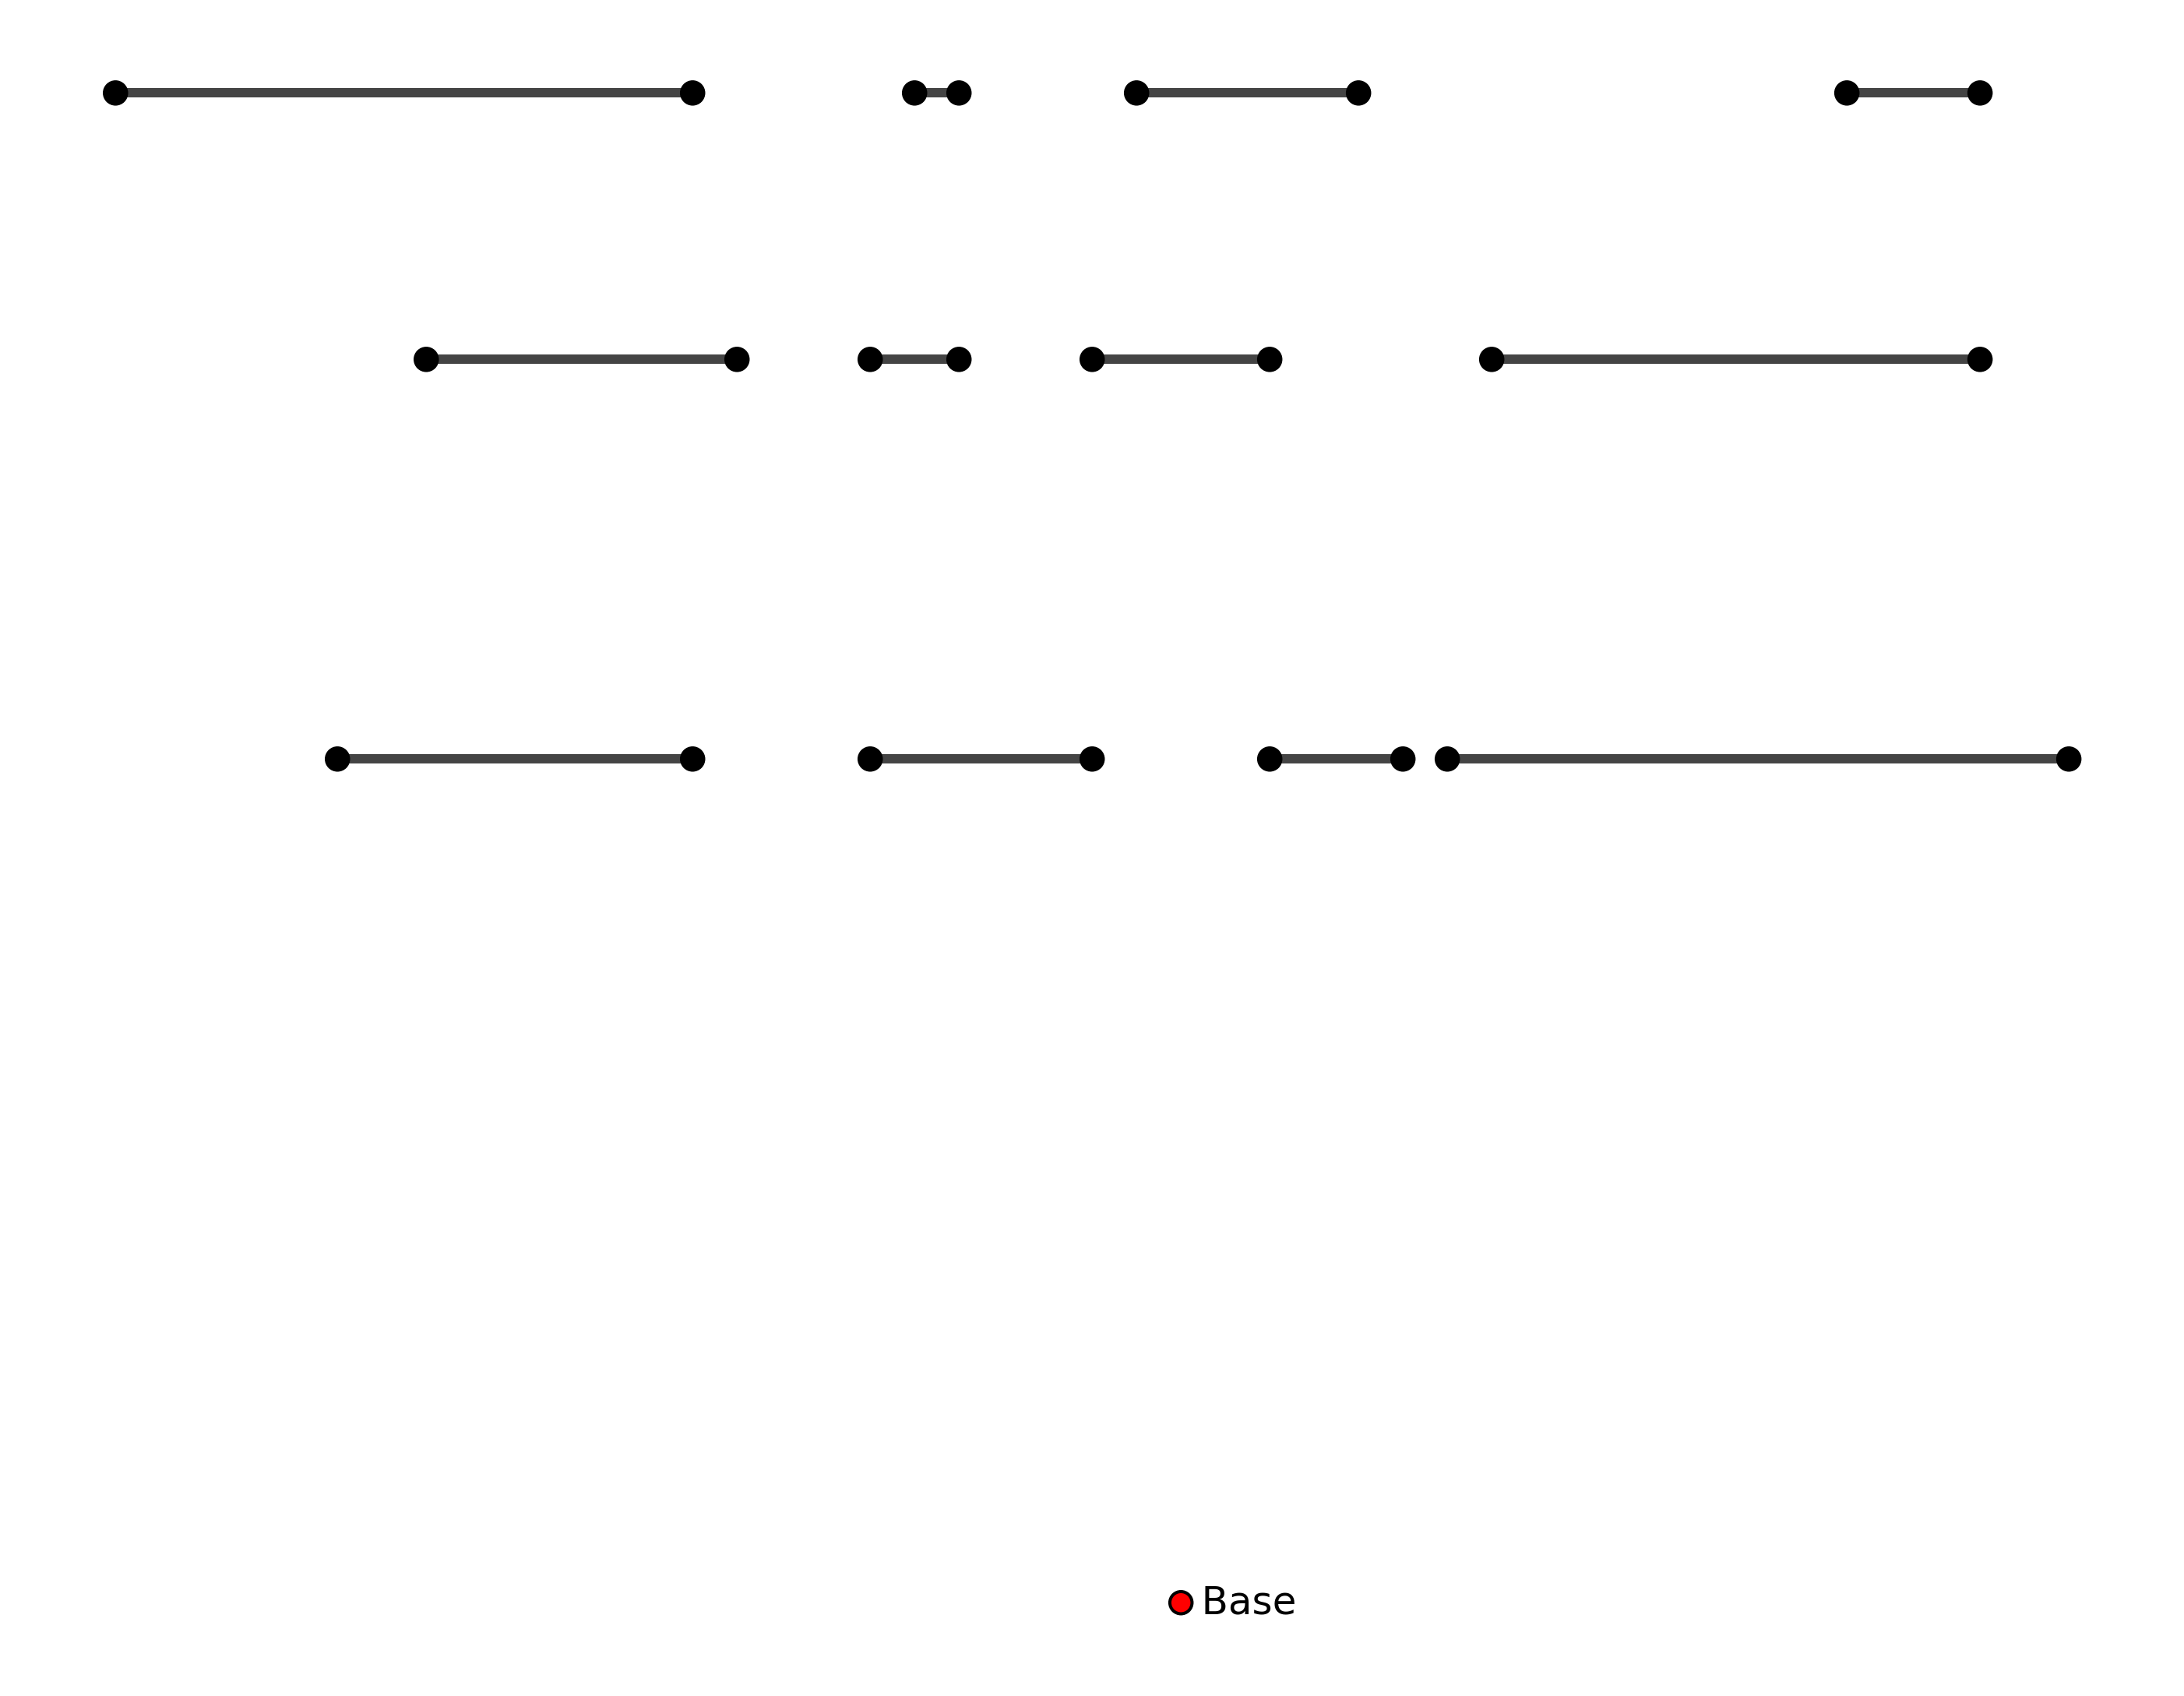

In [14]:
PlotTheGraph(g)

In [15]:
edge

array([[ 0.,  1.],
       [ 2.,  3.],
       [ 4.,  5.],
       [ 6.,  7.],
       [ 8.,  9.],
       [10., 11.],
       [12., 13.],
       [14., 15.],
       [16., 17.],
       [18., 19.],
       [20., 21.],
       [22., 23.]])

In [16]:
g.vs[2]

igraph.Vertex(<igraph.Graph object at 0x000002339513FA40>, 2, {'x': 18.0, 'y': 19.0, 'group': 1, 'base': False})

In [17]:
g_group = ig.Graph(n_vertices//2+1)

In [18]:
g.vs[24]["group"]=12

In [19]:
def PlotGroupGraph(g):
#    color_dict_vs = {True: "red", False: "black"}
#    edge_width = [2 + 10 * int(is_segment) for is_segment in g.es["is_segment"]]
#    vertex_color = [color_dict_vs[base] for base in g.vs["base"]]
    fig, ax = plt.subplots(figsize=(10,10))
    ig.plot(
        g,
        target=ax,
        layout='auto',
        vertex_size = 0.3,
        vertex_frame_width=4.0,
#        vertex_color = vertex_color,
#        edge_width = edge_width,
    )
    plt.show()

In [20]:
def chose_a_node(i):
    seg=np.where(np.asarray(g.vs["group"])==i)
    node=seg[0][0]
    if (np.shape(seg)[1]==2):
        if (g.degree(seg[0][0])>g.degree(seg[0][1])):
            node=seg[0][1]
    return node

In [21]:
k = np.asarray(g_group.degree())
n=6

while (np.sum(k<n)>1):
    i=np.argmin(k)
    k[i]+=1
    q = chose_a_node(i)
    
    sorted_indexes=np.argsort(k)
    ind=0
    j=sorted_indexes[ind]
    r = chose_a_node(j) 
    while g_group.are_connected(i, j):
        ind+=1
        j=sorted_indexes[ind]
        r = chose_a_node(j) 
        while (g.vs[q]["y"]==g.vs[r]["y"]):
            ind+=1
            j=sorted_indexes[ind] 
            r = chose_a_node(j)

    k[j]+=1
    if k[j]>n:
        k[j]-=1
        break     
        
    g_group.add_edges([(i,j)])
    print("groups: ",i, j)    
        
    print("connect nodes: ",q, r)
    g.add_edges([(q,r)])
    g.es[g.get_eid(q, r)]["is_segment"] = False  

    # Se conecta con alguien en la linea como cho una vez.
    # Conectar solo con el cercano de la linea
    # La idea sería adelantar los coneciones de los segmentos en la linea y
    # luego hacer las demas conecciones proibiendo por completo cenectar en la linea

groups:  0 1
connect nodes:  0 2
groups:  2 3
connect nodes:  4 6
groups:  4 5
connect nodes:  8 10
groups:  6 7
connect nodes:  12 14
groups:  8 9
connect nodes:  16 18
groups:  10 11
connect nodes:  20 22
groups:  12 0
connect nodes:  24 1
groups:  1 2
connect nodes:  3 5
groups:  3 4
connect nodes:  7 9
groups:  5 6
connect nodes:  11 13
groups:  7 8
connect nodes:  15 17
groups:  9 10
connect nodes:  19 21
groups:  11 12
connect nodes:  23 24
groups:  0 4
connect nodes:  0 8
groups:  1 5
connect nodes:  2 10
groups:  2 6
connect nodes:  4 12
groups:  3 7
connect nodes:  6 14
groups:  8 12
connect nodes:  16 24
groups:  9 0
connect nodes:  18 1
groups:  10 1
connect nodes:  20 3
groups:  11 2
connect nodes:  22 5
groups:  3 5
connect nodes:  7 11
groups:  4 6
connect nodes:  9 13
groups:  7 9
connect nodes:  15 19
groups:  8 10
connect nodes:  17 21
groups:  11 0
connect nodes:  23 0
groups:  12 1
connect nodes:  24 2
groups:  2 4
connect nodes:  4 8
groups:  3 6
connect nodes:  6 1

In [22]:
k

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

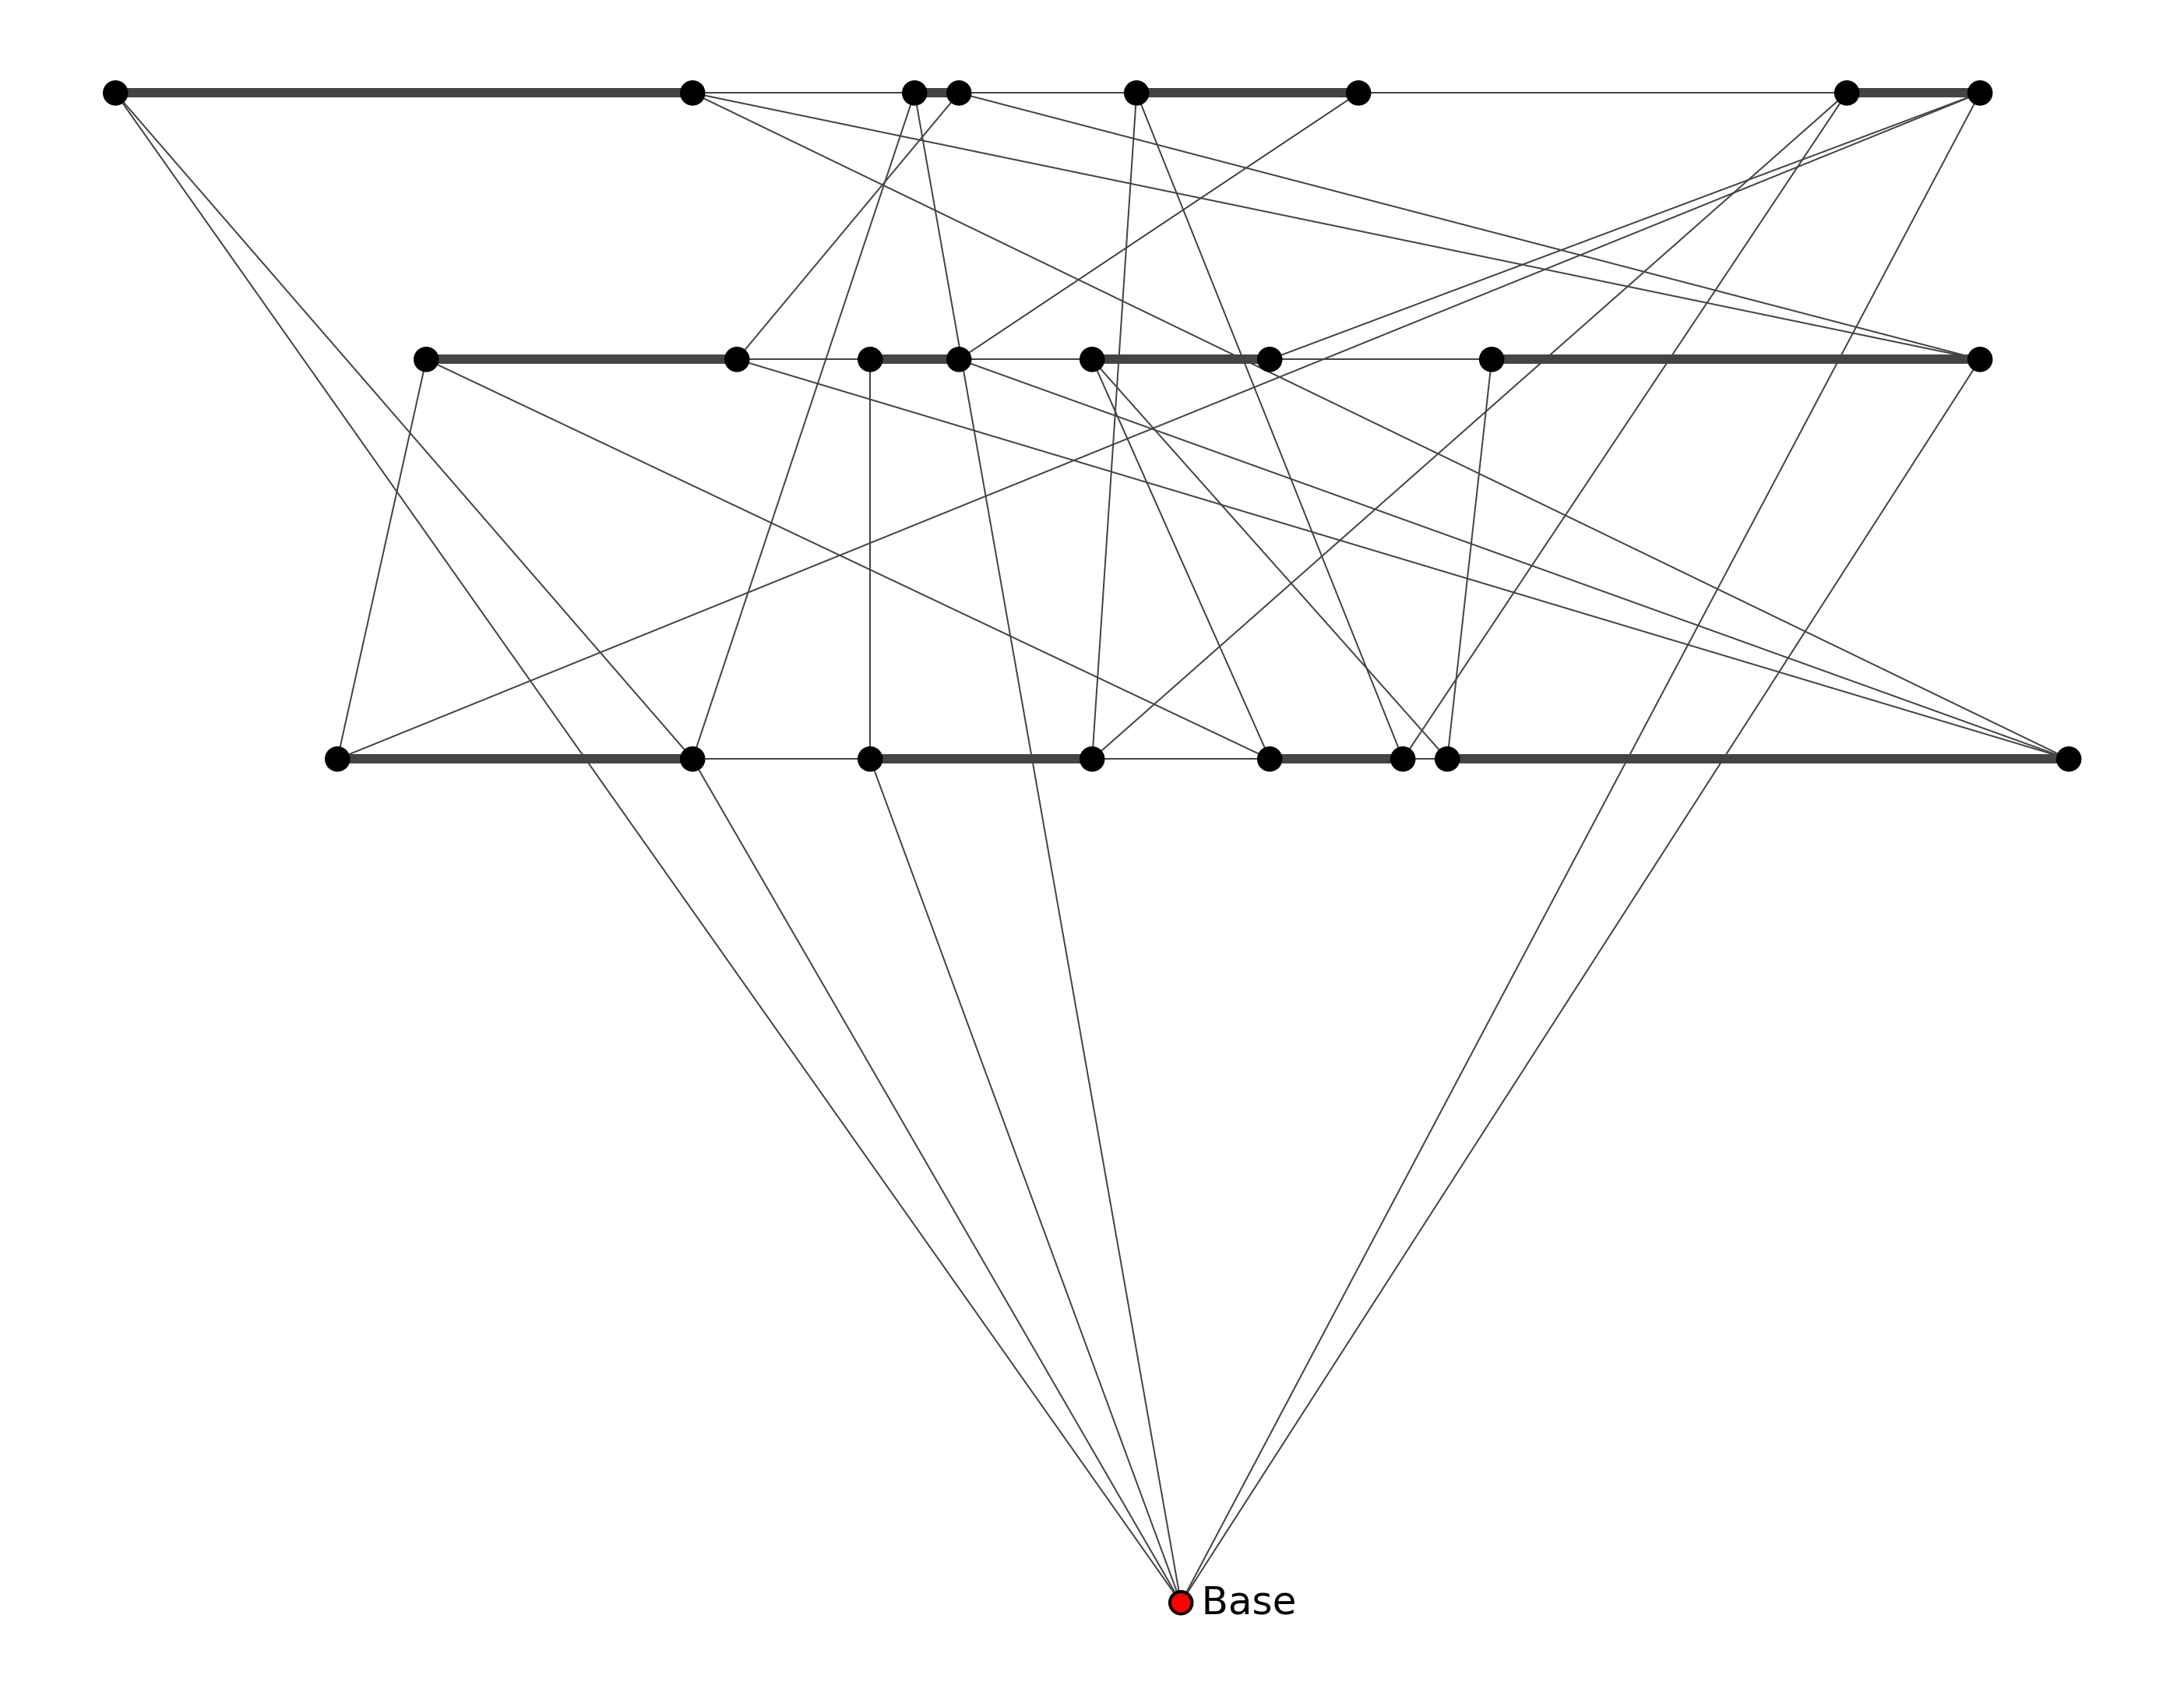

In [23]:
PlotTheGraph(g)

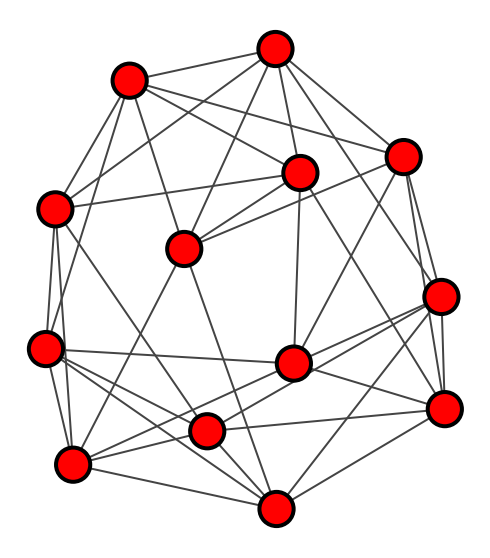

In [24]:
PlotGroupGraph(g_group)

In [25]:
k

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [26]:
np.argsort(k)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [27]:
k = np.asarray(g.degree())

In [28]:
k

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 6])

In [29]:
print(g_group)

IGRAPH U--- 13 39 --
+ edges:
 0 --  1  4  8  9 11 12    5 --  1  3  4  6  7 10   10 --  1  2  5  8  9 11
 1 --  0  2  5 10 11 12    6 --  2  3  4  5  7 11   11 --  0  1  2  6 10 12
 2 --  1  3  4  6 10 11    7 --  3  5  6  8  9 12   12 --  0  1  7  8  9 11
 3 --  2  4  5  6  7  8    8 --  0  3  7  9 10 12
 4 --  0  2  3  5  6  9    9 --  0  4  7  8 10 12


In [30]:
g.vs[q]["y"]

28.0